In [2]:
!pip install d2l
!pip install matplotlib==3.0.0
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd
import numpy as np



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 595 kB/s 
     |████████████████████████████████| 61 kB 8.8 MB/s 
     |████████████████████████████████| 11.2 MB 41.4 MB/s 
     |████████████████████████████████| 9.9 MB 47.0 MB/s 
     |████████████████████████████████| 15.7 MB 47.4 MB/s 
     |████████████████████████████████| 944 kB 49.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albu

In [ ]:

train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/testA.csv')

# 训练集特征处理
train_list = []
for items in train.values:
    train_list.append([items[0]] + [float(i) for i in items[1].split(',')] + [items[2]])
train = pd.DataFrame(np.array(train_list))
train.columns = ['id'] + ['s_' + str(i) for i in range(len(train_list[0])-2)] + ['label']  # 特征分离

# 测试集特征处理
test_list=[]
for items in test.values:
    test_list.append([items[0]] + [float(i) for i in items[1].split(',')])
test = pd.DataFrame(np.array(test_list))
test.columns = ['id'] + ['s_'+str(i) for i in range(len(test_list[0])-1)]  # 特征分离

print(train)

In [ ]:
# 查看训练集, 分离标签与样本, 去除 id
y_train = train['label']
x_train = train.drop(['id', 'label'], axis=1)
print(x_train.shape, y_train.shape)

# 查看测试集, 去除 id
X_test = test.drop(['id'], axis=1)
print(X_test.shape)

X_test = torch.tensor(np.array(X_test))



In [ ]:
import matplotlib.pyplot as plt

# 数据分析
# all_features.info()
# all_features.describe()
# all_features.isnull().sum()
plt.hist(train['label'], orientation = 'vertical', histtype = 'bar', color = 'red')
plt.show() 

# 发现数据集存在严重的类别不平衡的问题


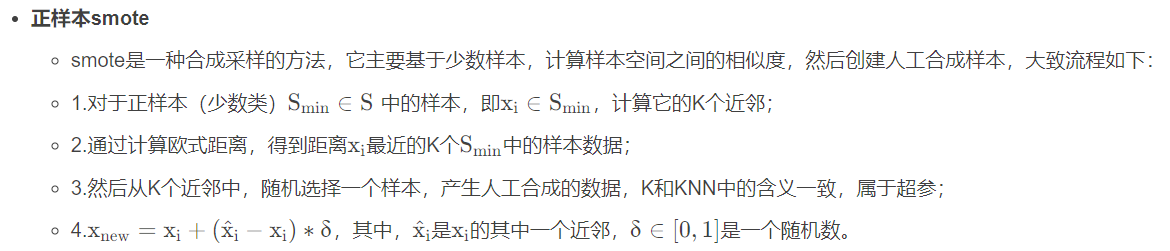

In [ ]:
# 正样本smote，可能导致过拟合
# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
from imblearn.over_sampling import SMOTE

# random_state：用于指定随机数生成器的种子，默认为None，表示使用默认的随机数生成器;
# k_neighbors：指定近邻个数，默认为5个;
# m_neighbors：指定从近邻样本中随机挑选的样本个数，默认为10个;
# n_jobs：用于指定SMOTE算法在过采样时所需的CPU数量，默认为1表示仅使用1个CPU运行算法，即不使用并行运算功能;-1表示使用所有cpu

smote = SMOTE(random_state=2021, n_jobs=-1)
k_x_train, k_y_train = smote.fit_resample(x_train, y_train)  
print(f"after smote, k_x_train.shape: {k_x_train.shape}, k_y_train.shape: {k_y_train.shape}")

k_x_train = torch.tensor(np.array(k_x_train))
k_y_train = torch.tensor(np.array(k_y_train))


In [ ]:
plt.hist(k_y_train, orientation = 'vertical', histtype = 'bar', color = 'blue')
plt.show() 

In [ ]:
# 评估函数
def abs_sum(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    loss = sum(sum(abs(y_pred-y_true)))
    return loss

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [ ]:
# 定义损失函数和模型
loss = nn.CrossEntropyLoss(reduction='none')
in_features = k_x_train.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64, 4))
  return net

k_x_train = k_x_train.to(torch.float32)
k_y_train = k_y_train.to(torch.float32)

net = get_net()
# net(k_x_train)

In [ ]:
# 交叉熵损失函数不需要处理k_y_train，会自动处理将其shape=(-1,4)

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # 使用Adam优化算法
  optimizer = torch.optim.Adam(net.parameters(),
                  lr = learning_rate,
                  weight_decay = weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y.long())
      l.sum().backward() # 梯度下降,若backward()函数计算的是标量则不需要指定参数，不需要sum()函数，
                # 若backward()函数计算的不是标量则需要使用sum()函数
      optimizer.step() # 优化参数
    # 将y转化为shape=(-1,4)
    i = 0
    y_train = torch.zeros_like(net(X))
    for item in y:
      j = np.array(item)
      y_train[i][j] = 1
      i += 1
    train_ls.append(abs_sum(net(X).detach(), y_train))
    if test_labels is not None:
      # 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
      test_ls.append(abs_sum(net(X).detach(), y_train)) 
  return train_ls, test_ls
  
  

In [ ]:
# 将数据分为k个部分，其中一部分为验证集
def get_k_fold_data(k, i, X, y):
  assert k>1
  fold_size = X.shape[0] // k # 向下取整
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size, (j+1)*fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid


In [ ]:
# k折交叉验证
# 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                   weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
    print(f'折{i + 1}，训练 rmse{float(train_ls[-1]):f}, '
              f'验证 rmse{float(valid_ls[-1]):f}')
  
  return train_l_sum / k, valid_l_sum / k

In [ ]:
# 定义超参数进行训练
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.00001, 0, 64
# 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
train_l, valid_l = k_fold(k, k_x_train, k_y_train, num_epochs, 
               lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练 rmse: {float(train_l):f}, '
      f'平均验证 rmse: {float(valid_l):f}')